## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "Helvetica"
# })
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')
rng = np.random.default_rng(2022)

## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [279]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)       

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [277]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T)#, np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [1224]:
def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)     

    # need to compute pseudo-inverse of L_{d x d}
    Lpinv = np.linalg.pinv(sp_graph.L.todense())  

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme 
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [1225]:
# Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Lpinv = np.linalg.pinv(sp_graph.L.todense())
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [(79,50,20)]), bounds=(0,1), method='bounded')
# [s for s in list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[75])) if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]
# spl = dict(nx.all_pairs_shortest_path_length(sp_graph))
# spl[0][12]
# np.argmin([nx.shortest_path_length(sp_graph,source=10,target=d) for d in set(range(sp_graph.n_observed_nodes))-set([10])])

In [ ]:
# sp_graph.c = 0
# dsigdL = np.zeros((sp_graph.n_observed_nodes**2,sp_graph.n_observed_nodes**2))
# idx = np.arange(sp_graph.n_observed_nodes**2).reshape(-1,sp_graph.n_observed_nodes).T[np.tril_indices(sp_graph.n_observed_nodes,k=-1)]   
# for I in idx:
#     i = I//sp_graph.n_observed_nodes; j = I%sp_graph.n_observed_nodes
#     dsigdL[I,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[i,j]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2

#     It = sp_graph.n_observed_nodes*j + i
#     dsigdL[It,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[j,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[It,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2
        
# s = sp_graph.lre[0][0]; d = sp_graph.lre[0][1]
# I = sp_graph.n_observed_nodes*d + s 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# ## do it for transpose too
# I = sp_graph.n_observed_nodes*s + d 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# for i in set(range(sp_graph.n_observed_nodes))-{s,d}:
#     I = sp_graph.n_observed_nodes*d + i
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

#     I = sp_graph.n_observed_nodes*i + d
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

# print(np.divide(dsigdL,np.repeat((obj.Linv**2).reshape(16,1),16,axis=0).reshape(16,16,order='F')))

# dLdw = np.zeros((sp_graph.n_observed_nodes**2,len(sp_graph.edges)))
# for I in range(len(sp_graph.edges)):
#     Ii = list(sp_graph.edges)[I][0]; Ij = list(sp_graph.edges)[I][1]

#     dLdw[sp_graph.n_observed_nodes*Ii + Ij, I] = -1
#     dLdw[sp_graph.n_observed_nodes*Ij + Ii, I] = -1

# for i in range(sp_graph.n_observed_nodes):
#     for j in np.where(sp_graph.Delta_q.toarray()[:,i])[0]:
#         dLdw[sp_graph.n_observed_nodes*i + i, j] = 1

# plt.spy(dLdw,aspect='auto',markersize=1)

# plt.imshow(dLdw[-500:,], aspect='auto', cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()
# plt.imshow(dLdw,aspect='auto',cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()

(3.9627958414810815, 3.451896453556947)

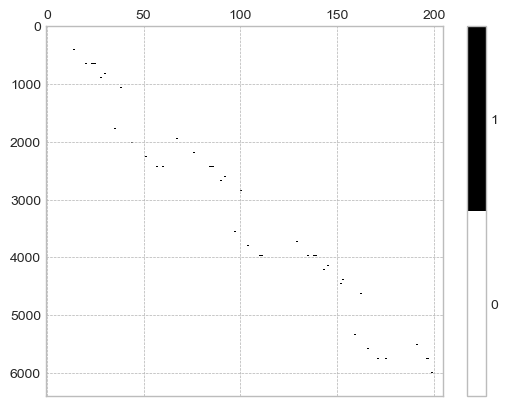

In [ ]:
# numd = len(sp_graph)
# sp_graph.c = 0
# dsigdL = np.zeros((numd**2,numd**2))
# idx = np.arange(sp_graph.n_observed_nodes**2).reshape(-1,sp_graph.n_observed_nodes).T[np.tril_indices(sp_graph.n_observed_nodes,k=-1)]   
# for I in idx:
#     i = I//sp_graph.n_observed_nodes; j = I%sp_graph.n_observed_nodes
#     dsigdL[I,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[i,j]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2

#     It = sp_graph.n_observed_nodes*j + i
#     dsigdL[It,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[j,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[It,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2
        
# s = sp_graph.lre[0][0]; d = sp_graph.lre[0][1]
# I = sp_graph.n_observed_nodes*d + s 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# ## do it for transpose too
# I = sp_graph.n_observed_nodes*s + d 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# for i in set(range(sp_graph.n_observed_nodes))-{s,d}:
#     I = sp_graph.n_observed_nodes*d + i
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

#     I = sp_graph.n_observed_nodes*i + d
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

# print(np.divide(dsigdL,np.repeat((obj.Linv**2).reshape(16,1),16,axis=0).reshape(16,16,order='F')))

# dLdw = np.zeros((numd**2,len(sp_graph.edges)))
# for I in range(len(sp_graph.edges)):
#     Ii = list(sp_graph.edges)[I][0]; Ij = list(sp_graph.edges)[I][1]

#     dLdw[numd*Ii + Ij, I] = -1
#     dLdw[numd*Ij + Ii, I] = -1

# for i in range(numd):
#     for j in np.where(sp_graph.Delta_q.toarray()[:,i])[0]:
#         dLdw[numd*i + i, j] = 1

# plt.spy(dLdw,aspect='auto'); plt.colorbar()

# plt.imshow(dLdw[-500:,], aspect='auto', cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()
# plt.imshow(dLdw,aspect='auto',cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()

In [3203]:
# new_max_idx = get_boot_edges(gen_test_2, sp_graph, coord_def, grid_def, edge_def, obj, lamb=1., nreps=20, ntop=50, nchoose=100,)
# te = [(15,56),(60,44)]
# badnodes = [item for sublist in te for item in sublist]
# [x for x in new_max_idx if x[0] not in badnodes and x[1] not in badnodes]
# df.A.value_counts().head(2)

inf

In [3205]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=7, n_samples_per_node=30)
# gen_test_2 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000)
sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim')
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(56,15),(20,68)]); sp_graph.c
# lle, te = get_best_lre(sp_graph, gen_test_2, coord_def, grid_def, edge_def, k=2, top=5, nchoose=100, option='hard')
# defw = sp_graph.w; defq = sp_graph.q
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint', long_range_edges=[(23,56)], c=0.2); #sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(23,56)], c=0.2) 
# jtw = sp_graph.w; jtq = sp_graph.q
# obj = Joint_Objective(sp_graph, option= 'joint'); obj.inv(); obj.grad(reg=False)
# grjt = obj.grad_obj
# plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$'); plt.show()
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

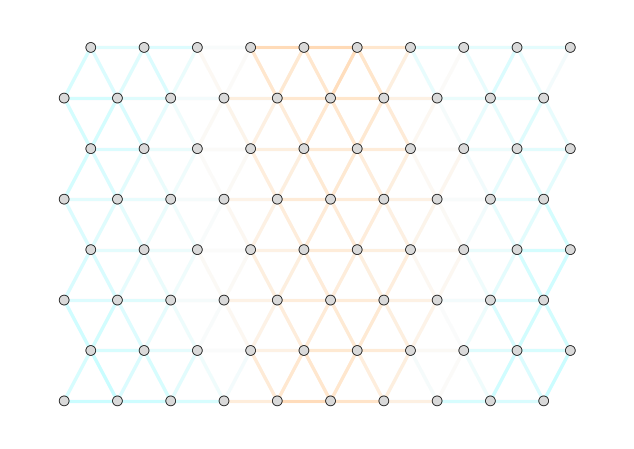

In [ ]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey');
# plt.plot(jtw0, jtw, 'ko'); plt.plot(defq,defq,ls='-',color='grey');

In [280]:
# J = np.zeros((np.sum(sp_graph.n_samples_per_obs_node_permuted),sp_graph.n_observed_nodes))
# cnt = 0
# for o in range(sp_graph.n_observed_nodes):
#     J[cnt:(cnt+sp_graph.n_samples_per_obs_node_permuted[o]+1),o] = 1
#     cnt += sp_graph.n_samples_per_obs_node_permuted[o]
# lrn=[(27,14)]
C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

# Pairs = sp_graph.n_samples_per_obs_node_permuted.reshape(-1,1,) @ sp_graph.n_samples_per_obs_node_permuted.reshape(1,-1) - np.diag(sp_graph.n_samples_per_obs_node_permuted)
# Dstar = squareform(pdist(J.T@sp_graph.genotypes,"sqeuclidean"))/1500/Pairs#J.T@(squareform(pdist(gen_test_1e,"sqeuclidean"))/gen_test_1e.shape[1])@J/Pairs
# Dstar = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1500 ## this does not give us good results (needs to be 'scaled' by SNP factor)
# Dstar = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1500
# resmat = -2*obj.Linv- np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T - np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) #np.zeros_like(obj.Linv) 
# resmat = -2*obj.Linv-2*np.diag(1/sp_graph.q)
# resmat = resmat - np.diag(resmat)
# for i in range(obj.Linv.shape[0]):
#     for j in range(i,obj.Linv.shape[0]):
#         resmat[i,j] = -2*obj.Linv[i,j] + Linv[i,i] + Linv[j,j] #+ sp_graph.q[i] + sp_graph.q[j]
#         resmat[j,i] = resmat[i,j]
#         if i==j:
#             resmat[i,i] -= 2/sp_graph.q[i]
Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Qmat = np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
# c = 0.01
# resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
# resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]
# for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
#     resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
#     resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
# plt.imshow(-C@Dstar@C.T); plt.colorbar(); plt.title(r'$-CDC^\top$'); plt.show()
# plt.imshow(-0.5*resmat,); plt.colorbar(); plt.title(r'$\Delta $')
# np.diag(C@resmat@C.T), sp_graph.q

# print(sp.stats.linregress(np.ravel(sp_graph.n_snps*C@sp_graph.S@C.T),np.ravel(-0.5*C@resmat@C.T)))
# plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-0.5*C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.xlabel(r'$pC\hat \Sigma C^\top$'); plt.ylabel(r'$-\frac{1}{2}C\Delta C^\top$'); 
# plt.plot(np.diag(sp_graph.n_snps*C@sp_graph.S@C.T),np.diag(-0.5*C@resmat@C.T),'ko',label='diagonal',alpha=0.6); plt.title(r'$c={}$'.format(c,0.975)); plt.legend();
# plt.imshow(2*C@sp_graph.S@C.T,cmap='Greys',); plt.colorbar(); plt.title('observed covariance matrix'); plt.show()
# plt.imshow(-C@resmat@C.T,cmap='Greys'); plt.title(r'$c=1.$'); plt.colorbar()
# plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],(-0.5*C@resmat@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-0.5*C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); 

ValueError: operands could not be broadcast together with shapes (80,73) (73,73) 

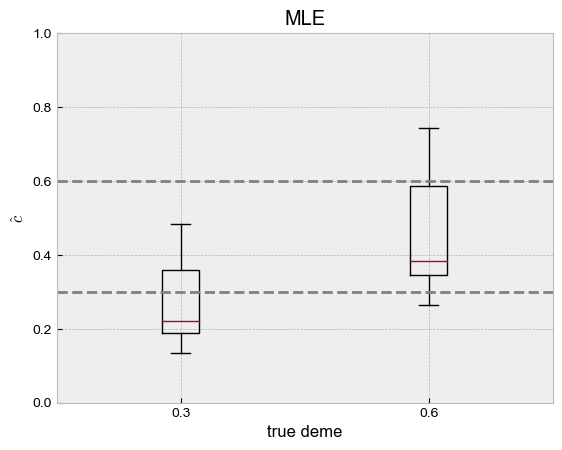

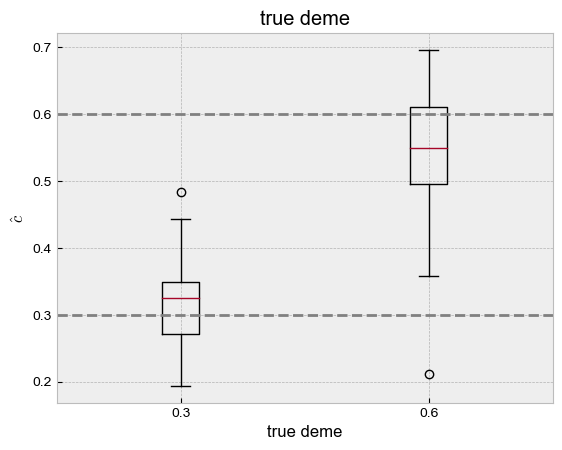

In [1460]:
# list(sp_graph.neighbors(23))
# list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[75]))
# neighs = [22,11,14,23] 
# [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]
# nx.get_node_attributes(sp_graph,'permuted_idx')[74]
# get_best_lre(sp_graph,k=1, lamb_cv=3., top=10, nboot=20, nchoose=100, option='base')
# MLEloc60
# MLEdist60 = [2, 0, 2, 1, 2, 2, 2, 2, 2, 0]; MLEdist = [3, 4, 0, 2, 1, 2, 3, 4, 0, 2]
# plt.scatter(range(1,11),np.sort(MLEdist)[::-1],color='lightblue',marker='D',s=75,label=r'$c=0.3$'); plt.yticks(range(5)); plt.ylabel('dist. from true deme'); plt.xlabel('replicate'); plt.scatter(range(1,11),np.sort(MLEdist60),color='dodgerblue',marker='o',label=r'$c=0.6$'); plt.legend()
# plt.scatter([3,5,9],np.array(MLEdist60)[np.array([2,4,8])],color='lightblue',marker='D'); 
# plt.scatter([2,4,10],np.array(MLEdist60)[np.array([1,3,9])],color='dodgerblue',marker='D',s=55);

# res60 = np.polyfit(np.abs(MLEc60-0.6),truell60,1); res = np.polyfit(np.abs(MLEc-0.3),truell,1)
# plt.scatter(np.abs(MLEc60-0.6),truell60,color='dodgerblue',alpha=0.8,label=r'$c=0.6$',s=(np.array(MLEdist60)+1)*70); plt.xlabel(r'$|c-\hat c|$'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(np.abs(MLEc-0.3),truell,color='lightblue',label=r'$c=0.3$',s=(np.array(MLEdist)+1)*70); plt.plot(np.abs(MLEc60-0.6),np.abs(MLEc60-0.6)*res60[0]+res60[1],color='dodgerblue'); plt.plot(np.abs(MLEc-0.3),np.abs(MLEc-0.3)*res[0]+res[1],color='lightblue'); plt.legend()

# plt.plot(np.r_[np.repeat(0.3,10),np.repeat(0.6,10)],np.r_[MLEc,MLEc60],'ko',alpha=0.5); plt.axline((0.3,0.3),slope=1,color='grey')
plt.boxplot(np.vstack((MLEc,MLEc60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.xlabel('true deme'); plt.title('MLE'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--'); plt.show();
plt.boxplot(np.vstack((truec,truec60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.xlabel('true deme'); plt.title('true deme'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--')
# plt.scatter(range(1,11),MLEdist,color='k',marker='x',s=np.abs(MLEc60-0.6)*400,label='sampled demes'); plt.yticks(range(5)); plt.plot([2,4,10],np.array(MLEdist)[np.array([1,3,9])],'ko',label='unsampled demes'); plt.legend(); plt.ylabel('dist. from true deme'); plt.xlabel('replicate')
# plt.scatter(range(1,11),truell60,color='dodgerblue',marker='o',s=np.abs(truec60-0.6)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(range(1,11),truell,color='lightblue',marker='o',s=np.abs(truec-0.3)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme')

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 121 iterations, train_loss=8271.820
lambda=3.000, alpha=0.5809, converged in 11 iterations, train_loss=7518.179
0.0 0.135 -32.0 0.255
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 122 iterations, train_loss=7482.347
lambda=3.000, alpha=0.5584, converged in 11 iterations, train_loss=6565.800
75.0 0.48310012673809705 0.0 0.48310012673809705
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 127 iterations, train_loss=7135.805
lambda=3.000, alpha=0.5872, converged in 13 iterations, train_loss=5924.212
2.0 0.22212222477952923 -18.0 0.33594240289830973
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 124 iterations, train_loss=7483.112
lambda=3.000, alpha=0.5746, converged in 11 iterations, train_loss=6536.428
73.0 0.39803334775823773 -70.0 0.23460292288408033
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converge

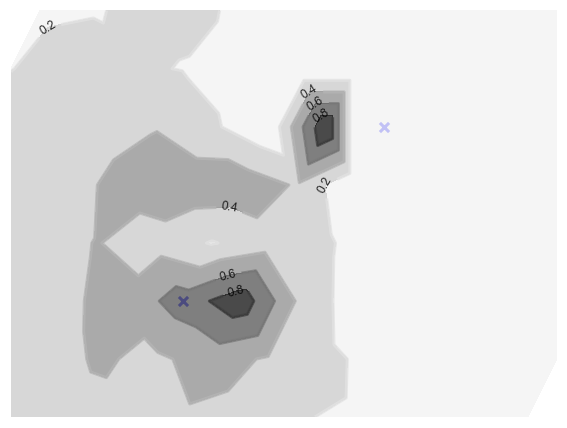

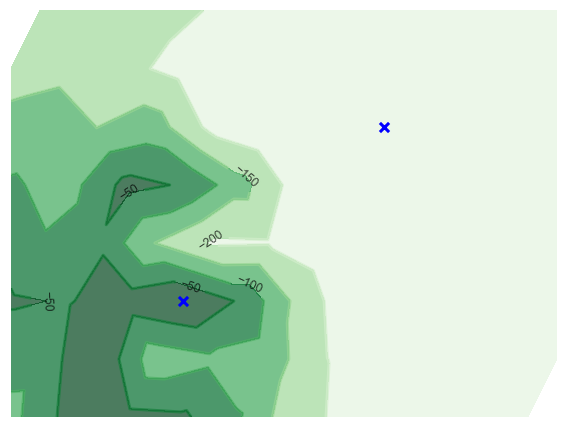

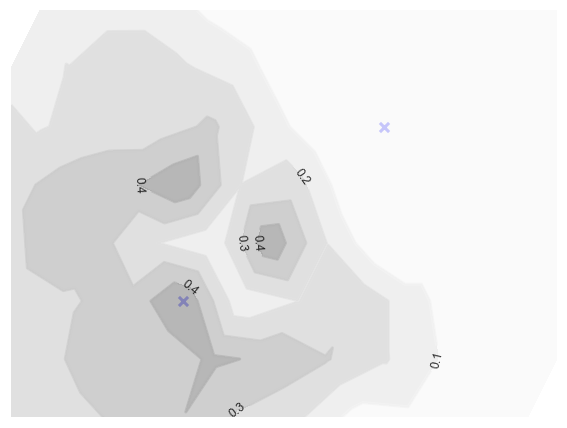

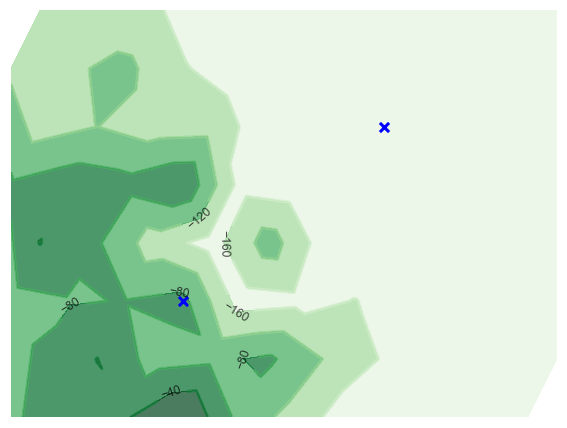

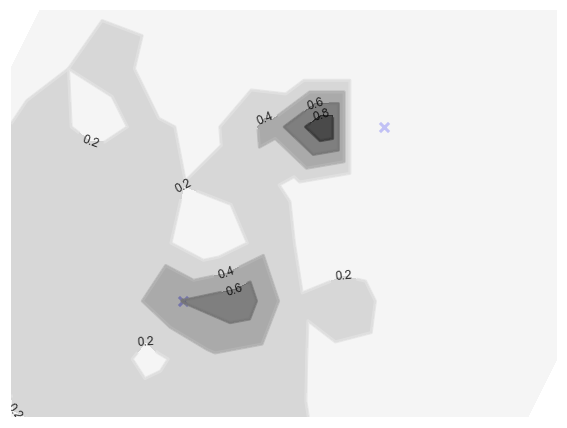

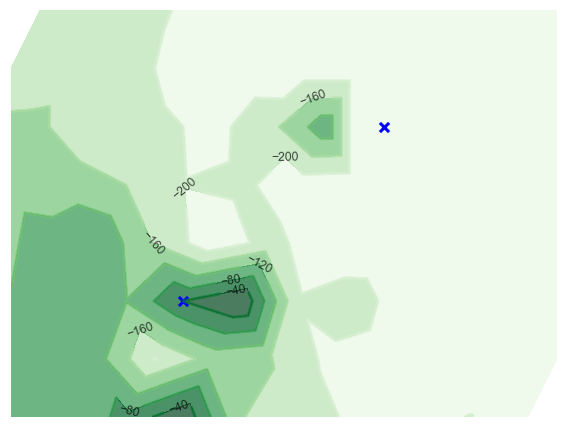

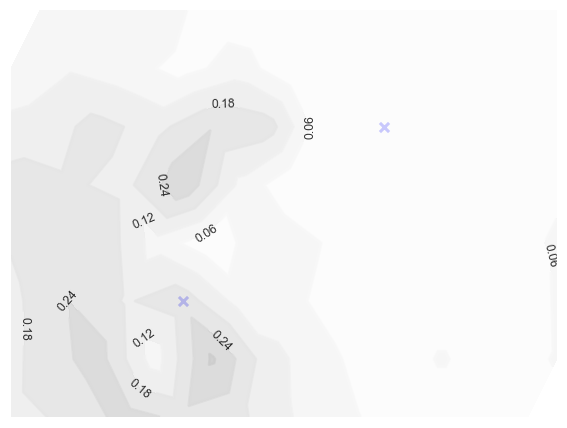

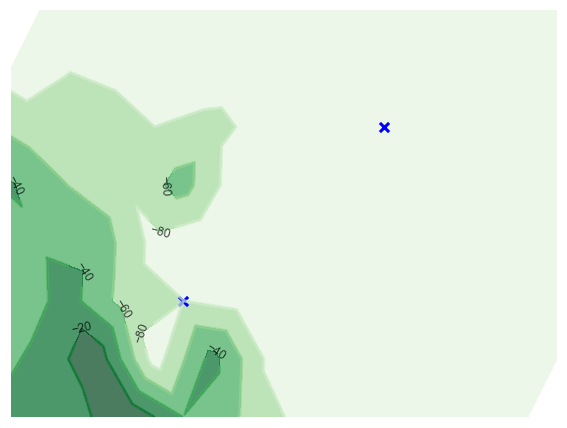

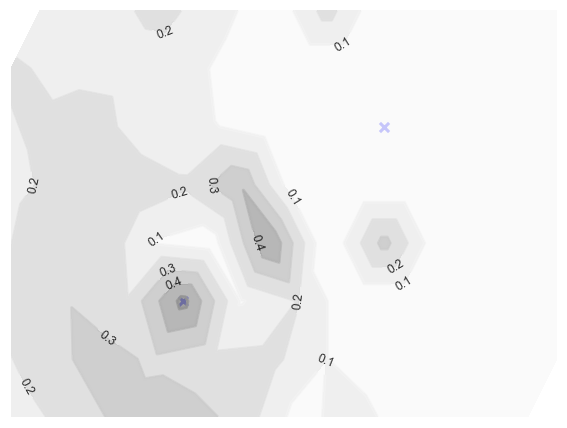

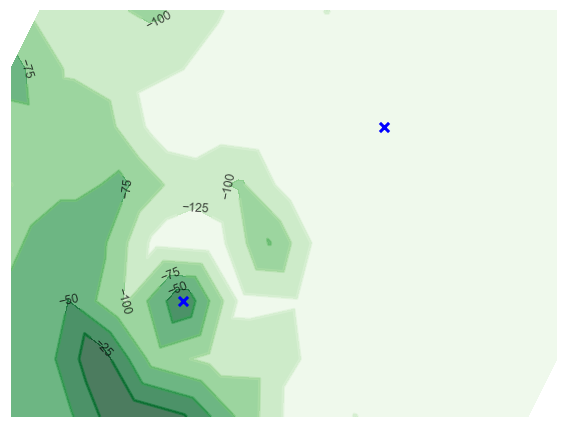

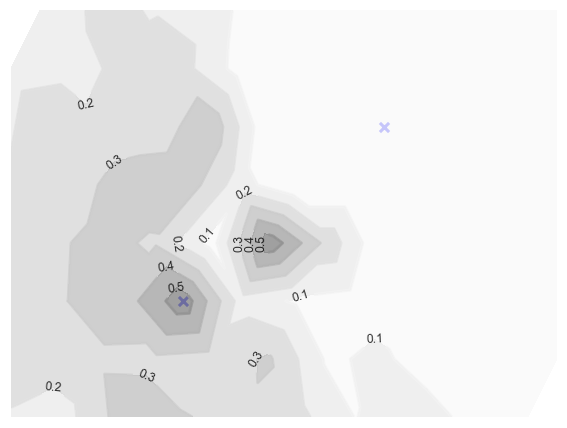

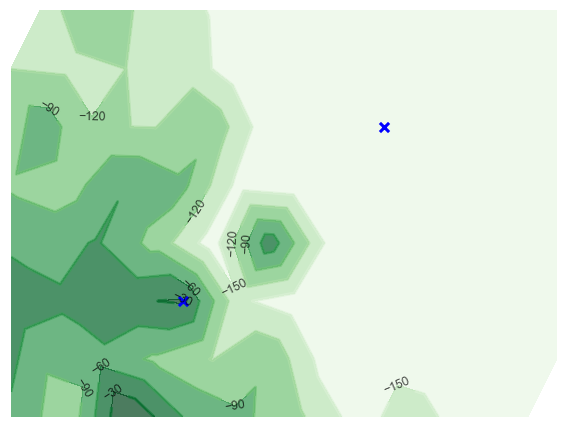

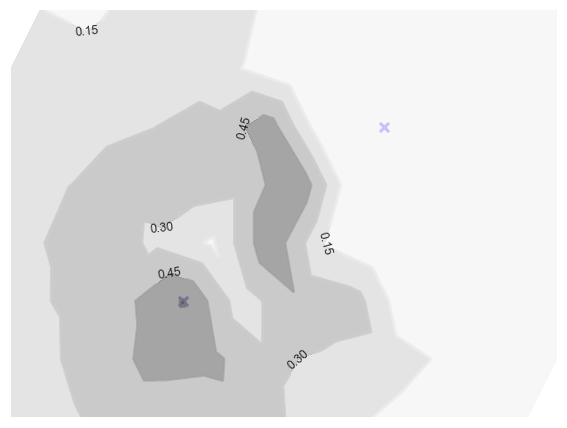

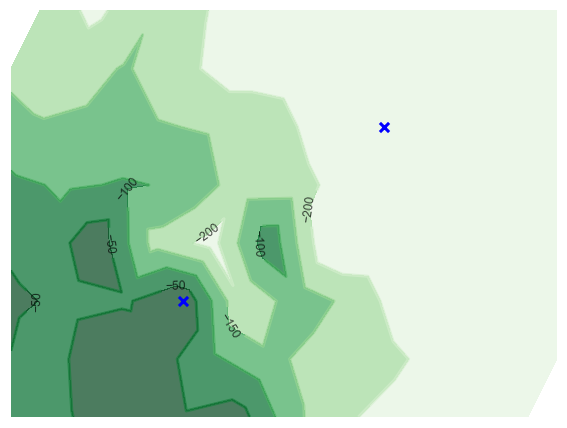

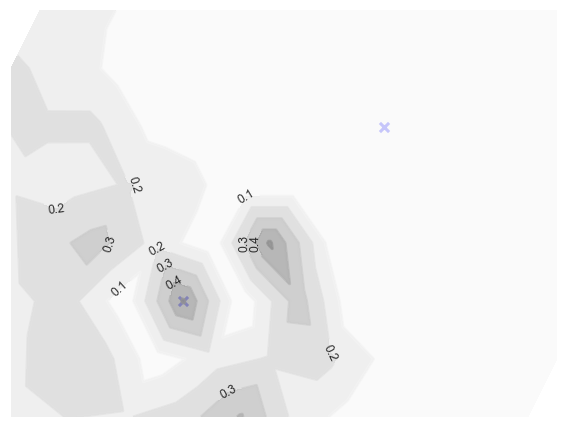

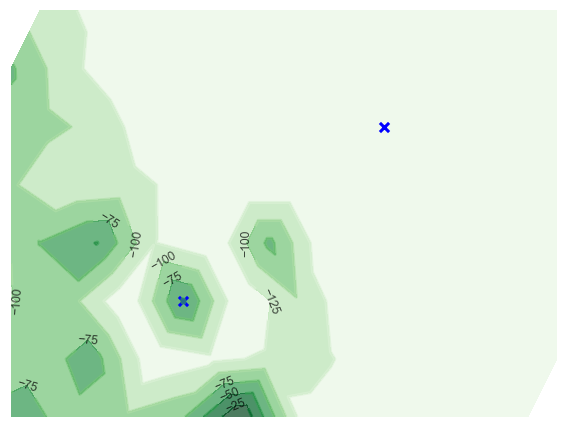

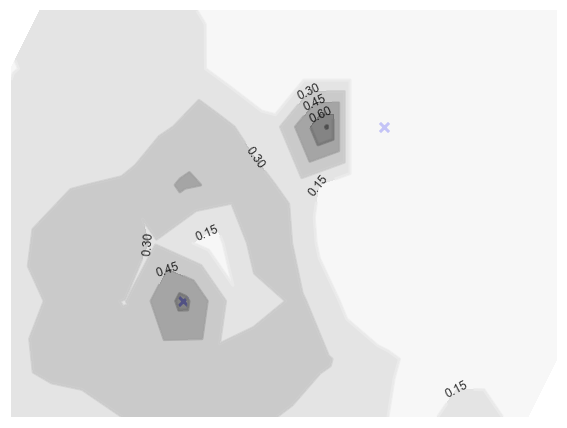

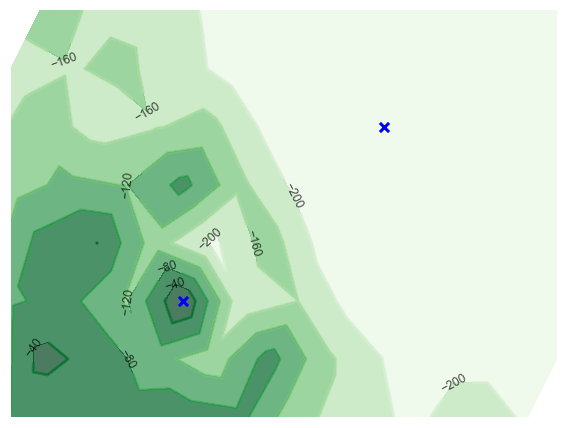

In [1320]:
# MLEloc60 = np.zeros(10); MLEc60 = np.zeros(10); truell60 = np.zeros(10); truec60 = np.zeros(10)
for i in range(10):
    gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[0.000001])
    # coord = coord_def[list(range(200))+list(range(210,740)),:]
    # gen_test = gen_test_80_adm[list(range(200))+list(range(210,740)),:]
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
    obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
    for ie, e in enumerate(randedge):
        if e[0]<73:
            res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
            isc2[ie] = res.x; llc2[ie] = res.fun
        else:
            res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
            isc2[ie] = res.x; llc2[ie] = res.fun

    MLEloc60[i] = np.argmin(llc2); MLEc60[i] = isc2[np.argmin(llc2)]
    truell60[i] = np.min(llc2)-llc2[75]; truec60[i] = isc2[75]
    
    fig = plt.figure(dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
    ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
    CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    fig = plt.figure(dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=5,extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=5,cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');

(79, 49)

In [1461]:
# n_rows, n_columns = 8, 10
# smallnodes = [12, 13, 22, 24, 32, 33] #list(np.random.randint(80,size=10)) 
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=2, ss=[0 if i in smallnodes else 20 for i in range(80)])

# lrn = [(23,56)] 
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.3], time_of_adm=[0.000001])

# coord = coord_def[list(range(200))+list(range(210,740)),:]
# gen_test = gen_test_80_adm[list(range(200))+list(range(210,740)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

# sp_graph = Joint_SpatialGraph(gen_test, coord, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[(12,49)]); sp_graph.c

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=True); 

# get_FEEMS_demes_nll_w_c(sp_graph.c, sp_graph, obj, [(19,49)]), get_FEEMS_udemes_nll_w_c(0.544,sp_graph,obj,[(19,49,79)])
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')
# sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')

lambda=2.000, alpha=0.5727, converged in 1 iterations, train_loss=6091.334


array([0.45])

In [1232]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(1000)]
# randedge = list(set(randedge)-set(sp_graph.edges))
randedge = [(x,49) for x in list(set(range(0,80))-set([49]))] 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,0,0,0])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55),(12,56),(13,56),(32,56)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def); 
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    if e[0]<73:
        res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        isc2[ie] = res.x; llc2[ie] = res.fun
    else:
        res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        isc2[ie] = res.x; llc2[ie] = res.fun
    # isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).fun
    # isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

In [1230]:
# isc2[randedge.index((20,50))] # 9794
# np.sort(llc2)
np.max(isc2)

0.1571662704129813

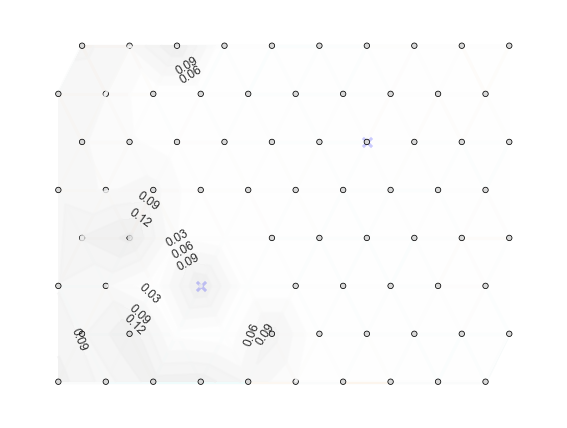

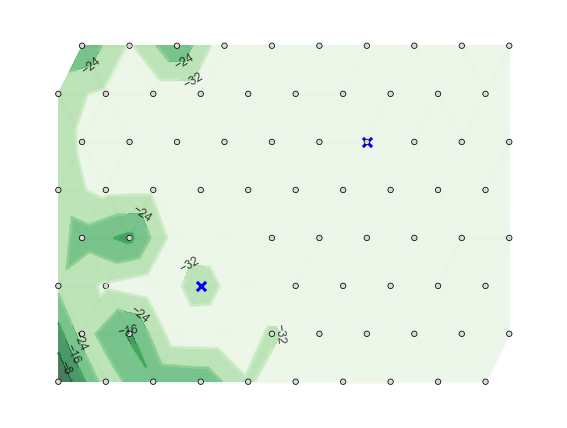

In [1233]:
# plt.style.use('fivethirtyeight')
# lrn=[(23,56)]
# plt.plot(grid_def[:,0],grid_def[:,1],'o',color='grey',alpha=0.8); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# plt.plot(grid_def[lrn[0][0],0],grid_def[lrn[0][0],1],'bo'); plt.plot(grid_def[lrn[0][1],0],grid_def[lrn[0][1],1],'bo'); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# for ie, e in enumerate(randedge):
#     plt.plot((grid_def[randedge[ie][0],0],grid_def[randedge[ie][1],0]),(grid_def[randedge[ie][0],1],grid_def[randedge[ie][1],1]),color='{}'.format(1-np.abs(isc2[ie]-truew[ie])),markersize=1)
# plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.Greys), orientation='vertical', label=r'$ |\hat c - c_{sim}|$')
# plt.style.use('seaborn-whitegrid')

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True); v.draw_obs_nodes(); 
# for ie in range(len(randedge[:50])):
#     v.draw_arrow([randedge[ie]],isc2[ie],fs=8)
#     v.draw_arrow([randedge[ie]],np.abs(-isc2[ie]+np.max(isc2))/1000-0.1,lw=1,hl=2,hw=5)
ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True); v.draw_obs_nodes(); 
ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=5,extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=5,cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=8, colors='k')
ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');

In [853]:
# plt.plot(-isc2,'ko',alpha=0.4); plt.xticks(ticks=range(len(randedge)),labels=randedge,rotation=45,size=2); plt.ylabel('log-lik units'); plt.grid()
# [randedge[i] for i in np.where((-isc2+np.min(isc2))>-250)[0]]
# np.vstack((np.meshgrid([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge], [v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge]),np.min(llc2)-llc2))

In [1037]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
n_rows, n_columns = 6, 6
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)

# lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[0.000001])
# gen_test_128_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[3])
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def, long_range_edges=[(23,56)])
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# estcR2mat = np.zeros((16,5)) 
# estcllmat = np.zeros((16,5))
# trueid = np.zeros((16,5))
# for ic, truec in enumerate([0,0.25,0.5,0.75,1.]):
    # for n in range(16):
        ## gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
        ## np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
        # gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
        # sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
        # sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False)
        # obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
        # fit_cov, _, emp_cov = comp_mats(obj)
        # fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        # estcllmat[n,ic] = sp.stats.norm.cdf(np.min(np.log(emp_dist/fit_dist)),np.mean(np.log(emp_dist/fit_dist)),np.std(np.log(emp_dist/fit_dist)))
        # obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
        # Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
        # Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
        # resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
        # llnull = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, option='joint', long_range_edges=lrn, verbose=False)
        # estcR2mat[n,ic] = sp_graph.c

        # if truec>0:
        #     lle, te = get_best_lre(sp_graph,k=1,top=20)
        #     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', long_range_edges=lrn, verbose=False); sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False)
        #     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
        #     estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        #     if te.iloc[np.argmax(lle),0]==(8,27):
        #         trueid[n,ic] = 1

In [1043]:
# estcllmat[:,0] = np.random.choice(cestsig,16)
# estcllmat[:,0] = -2*(llrand[:16,0]-llsig[:16])
# trueid.sum(axis=0)
# estcllmat[trueid[:,1]==1,1], estcllmat[trueid[:,1]==0,1]
gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(50,14),delimiter=',')
sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False); sp_graph.c
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

# reswt = sm.WLS(emp_dist, X, weights=fit_dist).fit()
# muw, betaw = reswt.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betaw*fit_dist+muw, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(reswt.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

array([0.496])

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


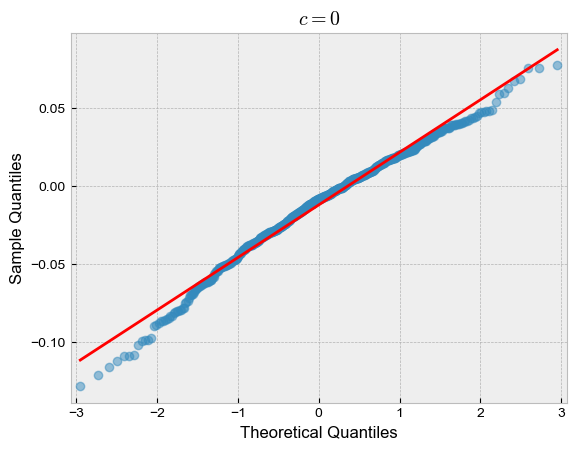

In [346]:
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi
# het_white(reswt.resid,X)
# res.get_robustcov_results(cov_type='HC0').pvalues
# studentized_residuals = olsi(reswt).resid_studentized
# leverage_pts = olsi(reswt).hat_matrix_diag
# cook_dist = olsi(reswt).cooks_distance

# sm.graphics.influence_plot(reswt, alpha  = 1e-6, criterion="cooks", plot_alpha=0.5)
# k = 572; x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)
# sns.residplot(x=X, y=emp_dist, lowess=True, color='grey'); 
# plt.plot(fit_dist,reswt.resid,'ko',alpha=0.3); plt.plot(fit_dist,res.resid,'bx',alpha=0.3)
# sm.OLS(emp_dist/fit_dist, fit_dist).fit().summary()
# plt.plot(emp_dist/fit_dist,fit_dist,'ko',alpha=0.3); 
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),15,color='grey'); plt.axvline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--')

sm.qqplot(np.log(emp_dist/fit_dist),line='r',color='grey',alpha=0.5); plt.title(r'$c=0$'); 

# sp.stats.norm.cdf(np.min(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.std(emp_dist/fit_dist))

In [255]:
# cestrand = np.zeros(50); cestsig = np.zeros(50); llrand = np.zeros((50,2)); llsig = np.zeros(50)
## 1. try fewer loci to see how it could effect the results (it bad...)
## 2. try a 70-30 split of the data for getting oulier edges and for estimating the admixture proportion
for n in range(50):
    gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(0,n),delimiter=',')
    print('In sim {}:'.format(n))

    idx = rng.choice(range(gen_test_36_adm.shape[1]),1000,replace=False)
    bootgenotypes = gen_test_36_adm[:,idx]
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    # llrand[n,0] = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

    lle, te = get_best_lre(sp_graph,k=1,top=5)

    bootgenotypes = gen_test_36_adm[:,list(set(range(gen_test_36_adm.shape[1]))-set(idx))]
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)

    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    llrand[n,0] = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T) 
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3,option='onlyc',long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False); 
    obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    llsig[n] = -obj.neg_log_lik_c(sp_graph.c); cestsig[n] = sp_graph.c

    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    randedge = [tuple(np.random.choice(range(36),size=2,replace=False)) for _ in range(1)]
    randedge = list(set(randedge)-set(sp_graph.edges) - set(te.iloc[np.argmax(lle),0])); 
    if len(randedge) == 0:
        randedge = [(8,27)]
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); 
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3,option='onlyc',long_range_edges=randedge,verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    # print('random edge is: ',randedge)
    llrand[n,1] = -obj.neg_log_lik_c(sp_graph.c); cestrand[n] = sp_graph.c
    # print(sp_graph.c)

In sim 0:
Starting search for edge 1...
Potential deme A:
6    3
1    2
Name: A, dtype: int64
Potential deme B:
34    2
33    2
11    1
Name: B, dtype: int64
(6, 34)
(6, 11)
(1, 34)
(1, 33)
(6, 33)
(34, 6), found at index 0.
admixture proportions:
[0.083]
In sim 1:
Starting search for edge 1...
Potential deme A:
23    2
25    1
11    1
Name: A, dtype: int64
Potential deme B:
25    1
29    1
24    1
Name: B, dtype: int64
(23, 25)
(25, 29)
(11, 24)
(23, 31)
(8, 35)
(35, 8), found at index 4.
admixture proportions:
[0.081]
In sim 2:
Starting search for edge 1...
Potential deme A:
24    2
12    1
30    1
Name: A, dtype: int64
Potential deme B:
34    3
35    2
Name: B, dtype: int64
(24, 34)
(12, 34)
(24, 35)
(30, 34)
(18, 35)
(35, 18), found at index 4.
admixture proportions:
[0.084]
In sim 3:
Starting search for edge 1...
Potential deme A:
11    1
7     1
1     1
Name: A, dtype: int64
Potential deme B:
11    3
18    2
Name: B, dtype: int64
(11, 18)
(7, 11)
(1, 11)
(6, 11)
(17, 18)
(11, 7),

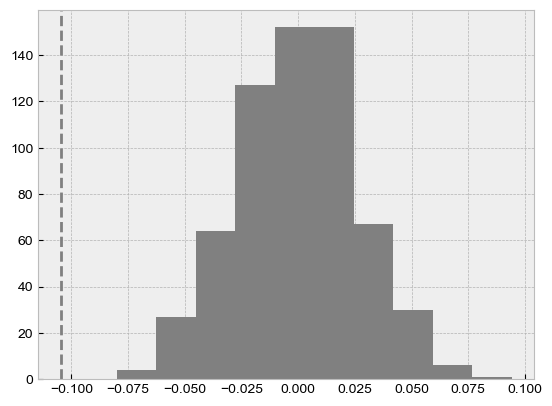

In [215]:
# plt.hist(cestrand,color='k',alpha=0.5,label='random edge'); plt.hist(cestsig,color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\hat{c}$')

# plt.hist(-2*(llrand[:,0]-llrand[:,1]),color='k',alpha=0.5,label='random edge'); plt.hist(-2*(llrand[:,0]-llsig),color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\lambda_{LR}$'); plt.axvline(6.5,color='grey',ls='--')
# plt.hist(cestrand[np.where(-2*(llrand[:,0]-llrand[:,1])>7)[0]],color='k',alpha=0.6,label='random edge'); plt.hist(cestsig[np.where(-2*(llrand[:,0]-llsig)>7)[0]],color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\hat{c}$'); plt.title('edges with p<0.01')
# sp.stats.chi2.sf(30,1)

# plt.hist(sp.stats.chi2.sf(-2*(llrand[:,0]-llsig),1),bins=25,color='g',alpha=0.5,label='top outlier edge'); plt.hist(sp.stats.chi2.sf(-2*(llrand[:,0]-llrand[:,1]),1),color='k',alpha=0.5,label='random edge',bins=25); plt.legend(); plt.xlabel(r'p-val');

Text(0.5, 1.0, 'top outlier edge')

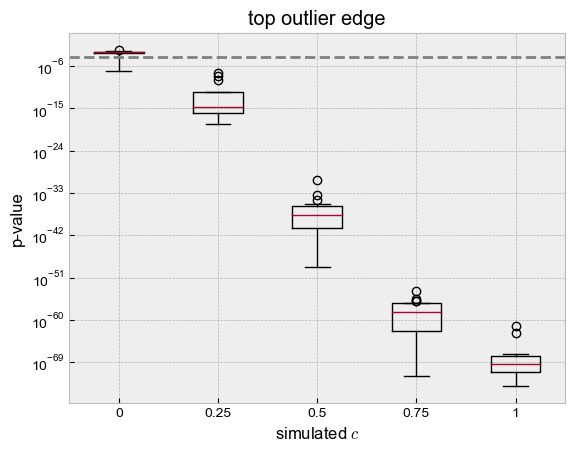

In [351]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = %.3f, joint optim w/ $L^{-1} M L^{-1,T}$'%np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3)); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('p-value'); plt.axhline(1e-4,color='grey',ls='--'); plt.semilogy(); plt.title('top outlier edge')
# np.sum(estcllmat[:,0]<5e-3)
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

# df = pd.DataFrame(np.random.rand(32,5), columns=[0,0.25,0.5,0.75,1])
# df['E'] = [r'joint optim, RMSE$ = 0.19$']*16+[r'stepwise optim, RMSE$ = 0.04$']*16
# df.iloc[:16,:5] = estcR2mat
# df.iloc[16:,:5] = estcllmat
# sns.violinplot(df.melt(id_vars=['E'], value_vars=[0,0.25,0.5,0.75,1]), cut=0, inner='box',x='variable', y='value', hue='E', palette='Set2'); plt.xlabel(r'simulated $c$'); plt.legend(loc='upper left'); plt.ylabel(r'estimated $c$'); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show()

In [1462]:
# np.sqrt(np.mean((df.iloc[16:,:5] - np.repeat([0,0.25,0.5,0.75,1],16).reshape(-1,5,order='F'))**2))

3.167124183311986e-05

In [ ]:
# lamb_grid = np.geomspace(1e-1,100,10,endpoint=True)[::-1]
# cvq_err = run_cv_joint(sp_graph_jt, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid)
# print(lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))])
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, long_range_edges=[(8,27)],c=0.2);
# sp_graph.fit(lamb=3.,optimize_q='n-dim',option='joint',lamb_q=3.,alpha_q=.3); sp_graph.c
# sp.optimize.minimize_scalar(get_grad_FEEMS_demes_nll_w_c,args=({'sp_graph':sp_graph,'obj':obj,'lrn':lrn}),bounds=(0,1),method='bounded').x

### Methods that DO NOT penalize long range edges (test the code here...)

The idea being that currently fitting graphs with many long range edges causes convergence issues, so we want to be able to add edges to the graph that are not constrained.

This will involve removing the penalty term + gradient term for these long range edges. Just need to index it correctly. 

In [ ]:
# edges_lr = deepcopy(edge_def)
# edges_lr = edges_lr.tolist()
# edges_lr.append(list(x+1 for x in (8,27)))
# sp_graph_lr = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(23,56)])
# sp_graph_lr.fit(lamb=3., optimize_q='n-dim')
# plt.hist(sp_graph_lr.w); plt.axvline(sp_graph_lr.w[25],color='k')
# obj_lr = Joint_Objective(sp_graph_lr); obj_lr.lamb = 3.; obj_lr.alpha = 0.5
# obj_lr.inv(); obj_lr.grad(reg=True)

estwsmat = np.zeros((14,30)); estwdmat = np.zeros_like(estwsmat)[:12,:] # 0:7 rows-penalizing LRE, 7:14 rows-not (dest mat does not need LRE again)
for ic, truec in enumerate([0]*10+[0.5]*10+[1]*10):
    gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),ic%10),delimiter=',')
    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr)); sp_graph.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

    sp_graph_lr = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(8,27)]) 
    try: 
        sp_graph_lr.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    except:
        sp_graph_lr.fit(lamb=4.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,8))]
        else:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,27))]
        else:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((27,n))]
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph_lr, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:56: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:59: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:65: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:69: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:187: RuntimeWarning: invalid value encountered in lo

In [ ]:
estwsmat = np.zeros((18,30)); estwdmat = np.zeros_like(estwsmat) # 0:7 rows-penalizing LRE, 7:14 rows-not (dest mat does not need LRE again)
os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture")
for ic, truec in enumerate([0]*10+[0.5]*10+[1]*10):
    gen_test_36_adm = np.loadtxt("gentest36_c{}_sim{}.csv".format(int(truec*100),ic%10),delimiter=',')
    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default',verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

    sp_graph_lr = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
    sp_graph_lr.fit(lamb=3., optimize_q='n-dim', verbose=False, long_range_edges=[(8,27)], option='joint'); 
    sp_graph_lr.fit(lamb=3.,optimize_q='n-dim', option='onlyc', long_range_edges=[(8,27)], verbose=False)
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,8))]
        else:
            estwsmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,27))]
        else:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((27,n))]

    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim', option='joint', long_range_edges=[(8,27)], verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

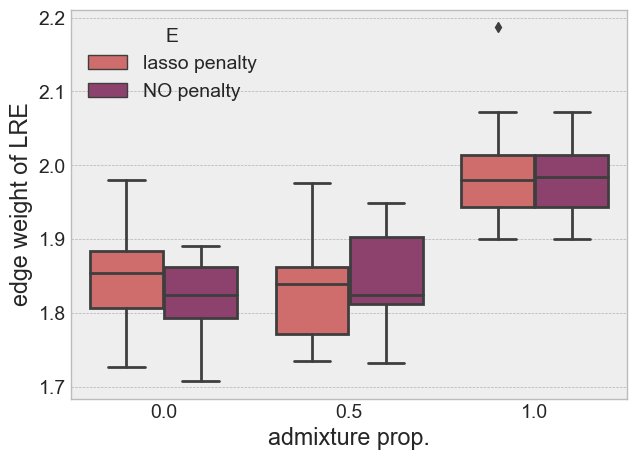

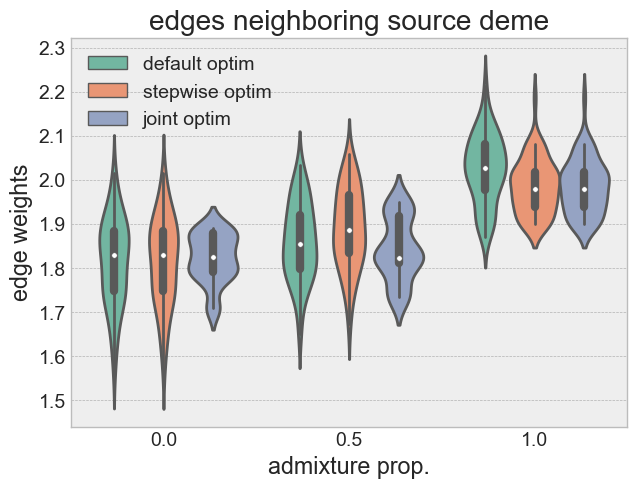

Ttest_indResult(statistic=5.84561729831843, pvalue=1.3977902153261863e-07)

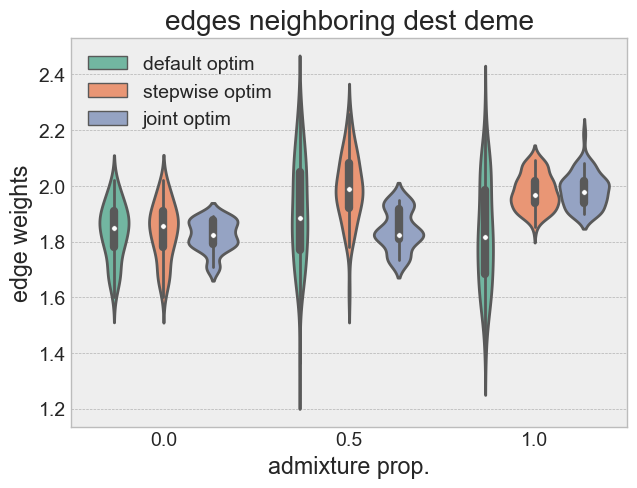

In [ ]:
## Delta is shape inds x edges
# df = pd.DataFrame(np.random.rand(20,3), columns=[0,0.5,1])
# df['E'] = ['lasso penalty']*10+['NO penalty']*10
# df.iloc[:10,0:3] = estwsmat[6,:].reshape(10,-1,order='F')
# df.iloc[10:,0:3] = estwsmat[13,:].reshape(10,-1,order='F')
# sns.boxplot(df.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='flare'); plt.xlabel('admixture prop.'); plt.ylabel('edge weight of LRE'); plt.show()

df2s = pd.DataFrame(np.random.rand(180,3), columns=[0,0.5,1])
df2s['E'] = ['default optim']*60+['stepwise optim']*60+['joint optim']*60
df2s.iloc[:60,0:3] = estwsmat[:6,:].reshape(60,-1,order='F')
df2s.iloc[60:120,0:3] = estwsmat[6:12,:].reshape(60,-1,order='F')
df2s.iloc[120:,0:3] = estwsmat[12:,:].reshape(60,-1,order='F') ## .loc[df2s['E'].isin(['default optim','stepwise optim'])]
sns.violinplot(df2s.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='Set2'); plt.legend(loc='upper left')
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring source deme'); plt.show()
sp.stats.ttest_ind(df2s.iloc[0:60,2],df2s.iloc[120:,2],equal_var=False)

df2d = pd.DataFrame(np.random.rand(180,3), columns=[0,0.5,1])
df2d['E'] = ['default optim']*60+['stepwise optim']*60+['joint optim']*60
df2d.iloc[:60,0:3] = estwdmat[0:6,:].reshape(60,-1,order='F')
df2d.iloc[60:120,0:3] = estwdmat[6:12,:].reshape(60,-1,order='F')
df2d.iloc[120:,0:3] = estwsmat[12:,:].reshape(60,-1,order='F')
sns.violinplot(df2d.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='Set2'); plt.legend(loc='upper left'); 
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring dest deme')
sp.stats.ttest_ind(df2d.iloc[60:120,2],df2d.iloc[:60,2],equal_var=False)

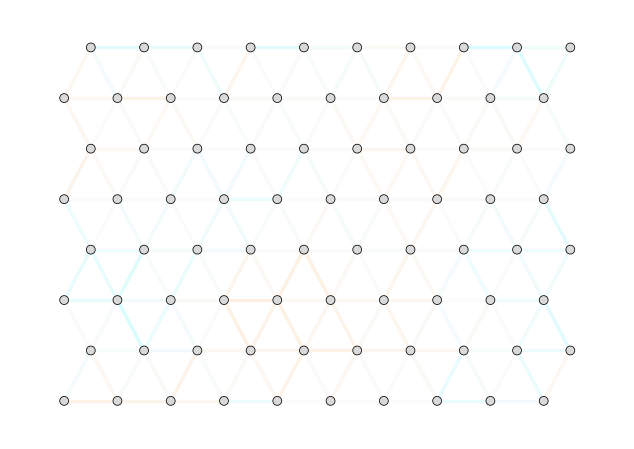

In [ ]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# get_best_lre(sp_graph, gen_test_36_adm, coord_def, grid_def, edge_def, k=2, top=20)
# max_res_nodes = [(8, 27), (3, 27), (2, 27), (7, 27), (9, 27), (1, 27), (5, 27), (6, 27), (14, 27), (15, 27), (13, 27), (0, 27), (12, 27), (4, 27), (5, 18), (10, 27), (11, 27), (18, 27), (5, 12), (5, 32)]
# ss = []; dd = []
# for e in max_res_nodes:
#     ss.append(e[0]); dd.append(e[1])
# for d in np.unique(dd):
#     print(np.sum(dd==d))
# df.d.value_counts()
# v.draw_edge_colorbar()
# v.draw_c_colorbar()

## Demes with small sample sizes

Scenarios:
1. NO long range edges but with few demes with small samples (<10% of larger demes)
2. ONE long range edge but between demes with large samples 

In [ ]:
# n_rows, n_columns = 8, 10
# smallnodes = [12, 62,  9, 37, 25, 48, 53, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 
# gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)

# sp_Graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_Graph.fit(lamb=3., optimize_q='n-dim')
# obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

# print(get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1, top=20))

# lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1)

# nreps = 30
# fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
# ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
# emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

for n in range(1,nreps+1):
    bootgenotypes = deepcopy(gen_test_80)
    ## if we bootstrap over SNPs, then we can do the below
    ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
    ## bootstrapping over inds (since this is the source of uncertainty)
    ctr = 0
    for deme in range(sp_Graph.n_observed_nodes):
        bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_80[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
        ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
    ## remove SNPs that are invariant after bootstrapping
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph_boot.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj_boot = Joint_Objective(sp_graph_boot)
    fit_cov, _, emp_cov = comp_mats(obj_boot)
    fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
    emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:57: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:60: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)


<ErrorbarContainer object of 3 artists>

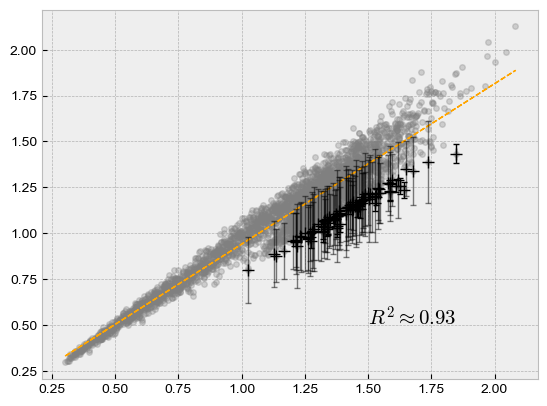

In [ ]:
# X = sm.add_constant(fit_dist[:,0])
# mod = sm.OLS(emp_dist[:,0], X)
# res = mod.fit()
# muhat, betahat = res.params
# # computing the standard errors from before
# se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
# for i in range(fit_dist.shape[0]):
#     se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
#     se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
# # finding the largest outliers, taking into account the SE might overlap with best-fit line
# max_idx = np.argpartition(res.resid, 100)[:100]
# max_idx = max_idx[np.argsort(res.resid[max_idx])]
# new_max_idx = []
# for i in max_idx:
#     if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
#         new_max_idx.append(i)

# new_max_res_node = []
# for k in new_max_idx:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     new_max_res_node.append(tuple(sorted((x,y))))

# plt.plot(fit_dist[:,0], emp_dist[:,0], 'o', color='grey', alpha=0.3, markersize=4)
# plt.plot(fit_dist[:,0], betahat*fit_dist[:,0]+muhat, color='orange', ls='--', lw=1)
# plt.text(1.5, 0.5, r'$R^2 \approx 0.93$', fontsize=15)
# plt.plot(fit_dist[max_idx,0], emp_dist[max_idx,0], '+', color='black', markersize=8)
# plt.errorbar(fit_dist[new_max_idx[20:],0], emp_dist[new_max_idx[20:],0], yerr=np.random.uniform(3,5,size=80)*se_emp[new_max_idx[20:]], color='k', lw=1, capsize=2, capthick=1, ls='none', alpha=0.5)
# plt.errorbar(fit_dist[new_max_idx[:20],0], emp_dist[new_max_idx[:20],0], yerr=se_emp[new_max_idx[:20]], color='black', lw=1, capsize=2, capthick=1, ls='none')

In [ ]:
## for the case with NO admixture BUT correction for standard errors
# llinc = np.zeros(30,); topedge = np.zeros((30,3),dtype='int'); 
# n_rows, n_columns = 8, 10
for n in range(4):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    # smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]

    # graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 

    # gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1200)
    # np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n),gen_test_1e,fmt='%f')
    gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n))

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    ## searching for best outlier node out of 20
    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1
    
    ## running the bootstrapping mechanism
    nreps = 20
    fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
    ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
    emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

    for n in range(1,nreps+1):
        bootgenotypes = deepcopy(gen_test_1e)
        ## if we bootstrap over SNPs, then we can do the below
        ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
        ## bootstrapping over inds (since this is the source of uncertainty)
        ctr = 0
        for deme in range(sp_Graph.n_observed_nodes):
            bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_1e[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
            ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
        ## remove SNPs that are invariant after bootstrapping
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
        sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord, grid, edge)
        sp_graph_boot.fit(lamb=3., optimize_q='n-dim',verbose=False)
        obj_boot = Joint_Objective(sp_graph_boot)
        fit_cov, _, emp_cov = comp_mats(obj_boot)
        fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
        emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

    X = sm.add_constant(fit_dist[:,0])
    mod = sm.OLS(emp_dist[:,0], X)
    res = mod.fit()
    muhat, betahat = res.params
    # computing the standard errors from before
    se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
    for i in range(fit_dist.shape[0]):
        se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
        se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
    # finding the largest outliers, taking into account the SE might overlap with best-fit line
    max_idx = np.argpartition(res.resid, 100)[:100]
    max_idx = max_idx[np.argsort(res.resid[max_idx])]
    new_max_idx = []
    for i in max_idx:
        if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
            new_max_idx.append(i)

    new_max_res_node = []
    for k in new_max_idx:
        x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
        y = int(k - 0.5*x*(x-1))
        new_max_res_node.append(tuple(sorted((x,y))))

    ll_edges = np.zeros((20,)); 
    for ie, e in enumerate(new_max_res_node[:20]):
        edges_t = deepcopy(edge.tolist())
        edges_t.append(list(x+1 for x in e))
        sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_t), long_range_edges=new_max_res_node[ie:(ie+1)])
        sp_graph_lr.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[ie] = -obj_lr.neg_log_lik()

    print(new_max_res_node[np.argmax(ll_edges)])

    if ee not in new_max_res_node:
        print("sim {}: top edge NOT found after correction. {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))
    else:
        print("sim {}: {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))

constant-w/variance fit, converged in 97 iterations, train_loss=-12150.6965079
lambda=3.0000000, alpha=0.7951398, converged in 12 iterations, train_loss=-13052.9709750
Starting search for edge 1...
(12, 37), found at index 0.
constant-w/variance fit, converged in 101 iterations, train_loss=-12294.3420486
lambda=3.0000000, alpha=0.8085983, converged in 9 iterations, train_loss=-14193.3519312
(71, 78)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 109 iterations, train_loss=-12597.5124677
lambda=3.0000000, alpha=0.7561121, converged in 13 iterations, train_loss=-13365.8670281
Starting search for edge 1...
(37, 70), found at index 12.
constant-w/variance fit, converged in 101 iterations, train_loss=-12658.8789305
lambda=3.0000000, alpha=0.7802661, converged in 11 iterations, train_loss=-14334.4936021
(46, 70)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 108 iterations, train_loss=-13741.6

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24770.7137127
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24726.0988225
Starting search for edge 1...
(10, 19), found at index 2.
constant-w/variance fit, converged in 130 iterations, train_loss=26671.6679895
lambda=3.0000000, alpha=0.7897206, converged in 9 iterations, train_loss=24737.2838198
Simulating ~SNP 1000
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 11 iterations, train_loss=22549.6017338
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 12 iterations, train_loss=22512.3157933
Starting search for edge 1...
(20, 47), found at i

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(31, 37), found at index 5.
constant-w/variance fit, converged in 109 iterations, train_loss=24465.4396872
lambda=3.0000000, alpha=0.8535564, converged in 9 iterations, train_loss=22482.3657553
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22228.1237432
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22178.8651371
Starting search for edge 1...
(7, 9), found at index 8.
constant-w/variance fit, converged in 116 iterations, train_loss=24259.0332885
lambda=3.0000000, alpha=0.8126157, converged in 9 iterations, train_loss=22208.1687858
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 119 iterations, train_loss=26552.6153684
lambda=3.0000000, alpha=0.8054896, converged in 9 iterations, train_loss=24239.8998599
constant

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(7, 70), found at index 12.
constant-w/variance fit, converged in 112 iterations, train_loss=24813.7208425
lambda=3.0000000, alpha=0.8521788, converged in 9 iterations, train_loss=22873.3675732
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24907.1432253
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24858.0611572
Starting search for edge 1...
(33, 37), found at index 13.
constant-w/variance fit, converged in 117 iterations, train_loss=26746.2388384
lambda=3.0000000, alpha=0.7944864, converged in 10 iterations, train_loss=24878.8607123
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 123 iterations, train_loss=25291.8320730
lambda=3.0000000, alpha=0.7988672, converged in 11 iterations, train_loss=23396.8404836
con

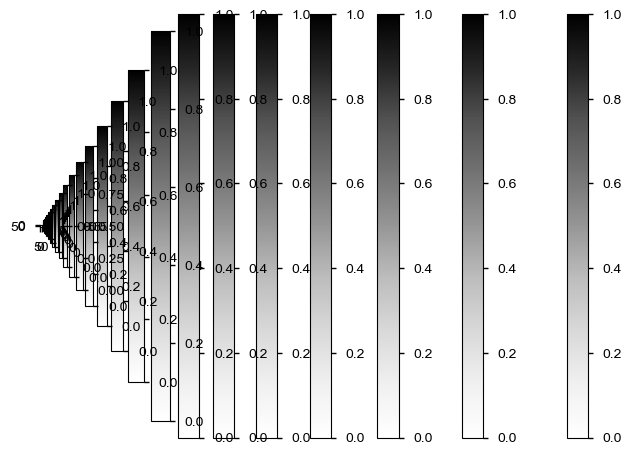

In [ ]:
## for the case with NO admixture
cnt = 0; llinc = np.zeros(20,); topedge = np.zeros((20,3),dtype='int')
### llinc[:25] = deepcopy(llinc_null); topedge[:25,:] = deepcopy(topedge_null)
n_rows, n_columns = 8, 10
for n in range(20):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]
    graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[2 if i in smallnodes else 20 for i in range(80)]) 
    # lrn = [(23, 56)]

    gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)
    # gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=2000, n_print=250, long_range_nodes=lrn, admixture_props=[0.25], time_of_adm=[0.00001])

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim')
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1  

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 7 iterations, train_loss=-36602.9242113
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 9 iterations, train_loss=-36108.4227041
Starting search for edge 1...
(23, 56), found at index 1.
constant-w/variance fit, converged in 124 iterations, train_loss=-35432.6499801
lambda=3.0000000, alpha=0.5884000, converged in 7 iterations, train_loss=-36745.6293496
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 7 iterations, train_loss=-36998.1243836
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 10 iterations, train_loss=-36566.2673286
Starting search for edg

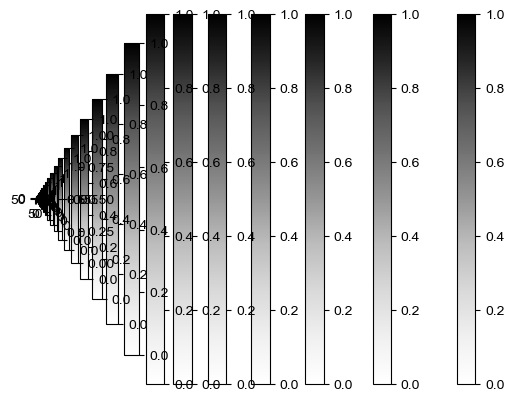

In [ ]:
## for the case with admix prop c = [0.25, 0.5, 0.75]
llinc = np.zeros((2,3)); topedge = pd.DataFrame(index=range(2),columns=['0.2','0.5','0.8'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=30) 
# lrn = [(23, 56)]
for ic, simc in enumerate([0.2,0.5,0.8]):
    for n in range(2):
        gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim')
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]

In [ ]:
res_edges[0]

False

In [ ]:
## for the case with admix prop c = [0.25, 0.5, 0.75] but with bootstrapping
llinc = np.zeros((15,4)); topedge = pd.DataFrame(index=range(15),columns=['0.125','0.25','0.375','0.5']); estc = np.zeros_like(llinc)
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=20) 
# lrn = [(23, 56)]
# lrnidx = np.zeros((15,3))
# lrnidx_ashr = np.zeros((15,3))
for ic, simc in enumerate([0.125,0.25,0.375,0.5]):
    if ic<3:
        continue
    cntrec = 0; cnttot = 0
    print('for c={}...'.format(simc))
    for n in range(15):
        ## gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])
        ## np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n),gen_test_1e)

        # gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n))

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim', lamb_q=3., alpha_q=0.3, verbose=False); 
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        # res_edges = comp_genetic_vs_fitted_distance(sp_Graph, n_lre=1000, lamb=3., plotFig=False, joint=True)[1]
        try:
            lle, res_edges = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, obj, k=1, nchoose=500)
        except:
            lle, res_edges = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, obj, lamb_cv=.1, k=1, nchoose=500)

        try: 
            print('Found in index: %d'%res_edges[0].tolist().index(lrn[0]))
        except:
            print('Not found in sim %d'%n)

        topedge.iloc[n,ic] = res_edges[0][np.argmax(lle)]
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2]
        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge, long_range_edges=[topedge.iloc[n,ic]])
        sp_Graph.fit(lamb=3., optimize_q='n-dim', lamb_q=3., alpha_q=0.3, verbose=False); 
        sp_Graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', lamb_q=3., alpha_q=0.3, verbose=False)
        estc[n,ic] = sp_Graph.c
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,ntop=600,nchoose=600)
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,nreps=30,ntop=600,nchoose=1500,option='ashr')
        # try:
        #     lrnidx_ashr[n,ic] = res_edges.index(lrn[0])
        # except:
        #     lrnidx_ashr[n,ic] = 1000
        # cntrec += lrn[0] in res_edges
        # print('{}/{} out of 15'.format(cntrec,cnttot))
    
        # lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
         
        # topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]
        # if (23,56) in new_max_res_node:
        #     print('sim {}: lrn not lost under bootstrapping!'.format(n))
        # else:
        #     print('sad :(')

for c=0.5...
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 113 iterations, train_loss=-23498.934
lambda=3.000, alpha=0.5883, converged in 5 iterations, train_loss=-24857.924
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 108 iterations, train_loss=-22597.168
lambda=3.000, alpha=0.6281, converged in 5 iterations, train_loss=-23716.981
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 120 iterations, train_loss=-23909.087
lambda=3.000, alpha=0.5966, converged in 4 iterations, train_loss=-25124.493
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(33, 56), found at index 15.
constant-w/variance fit, converged in 116 iterations, train_loss=-23960.894
lambda=3.

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))


(23, 56), found at index 0.
constant-w/variance fit, converged in 113 iterations, train_loss=-23065.114
lambda=3.000, alpha=0.6276, converged in 4 iterations, train_loss=-24208.044
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:348: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:352: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:366: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(23, 56), found at index 0.
constant-w/variance fit, converged in 112 iterations, train_loss=-23155.131
lambda=3.000, alpha=0.6073, converged in 5 iterations, train_loss=-24493.314
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 111 iterations, train_loss=-21175.856
lambda=3.000, alpha=0.6428, converged in 4 iterations, train_loss=-22551.269
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 117 iterations, train_loss=-25100.671
lambda=3.000, alpha=0.5858, converged in 4 iterations, train_loss=-26298.477
Found in index: 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 117 iterations, train_loss=-23875.383
lambda=3.000, alpha=0.5930, converged in 5 iterations, train_loss=-25049.391
Found in index: 0
Simulating ~SNP

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:348: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:352: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:366: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 116 iterations, train_loss=-23929.662
lambda=0.100, alpha=0.6001, converged in 31 iterations, train_loss=-25421.683
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 135 iterations, train_loss=-23881.022
lambda=3.000, alpha=0.5945, converged in 5 iterations, train_loss=-25163.596
Found in index: 0


In [ ]:
## still need to run the estimation for c=0 (do it manually and just print the results)
# import ast
# te = pd.read_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt',).iloc[:,1:]
# topedge = te.applymap(lambda x: ast.literal_eval(x))
# pd.read_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt',sep=',',names=[0,0.125,0.25,0.375,0.5])
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')
# topedge.iloc[:,:3] = tt
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')
# topedge.insert(0,'0',[(1,33)]*15)
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')

In [ ]:
# idx = []; truec = []
# for i in range(15):
#     for j in range(5):
#         if topedge.iloc[i,j]==lrn[0]:
#             idx.append(2); truec.append([0,0.125,0.25,0.375,0.5][j])
#         elif topedge.iloc[i,j][0] in sp_Graph.neighbors(23) or topedge.iloc[i,j][1] in sp_Graph.neighbors(56):
#             idx.append(1); truec.append([0,0.125,0.25,0.375,0.5][j])
#         else:
#             idx.append(0); truec.append(0)
# idx, truec
# plt.style.use('seaborn-whitegrid')
# fig = plt.figure(dpi=140)
# sns.swarmplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[0,0.125,0.25,0.375,0.5]*15,idx,)).T,columns=['llinc','edge','true demes?']),x='edge',y='llinc',hue='true demes?',legend='full',alpha=0.8,s=5,); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.axhline(2,color='grey',ls='--',linewidth=2);
# fig = plt.figure(dpi=140)
# sns.stripplot(data=pd.DataFrame(np.vstack((np.abs(estc-np.reshape(truec,(15,5))).flatten()**2,[0,0.125,0.25,0.375,0.5]*15,idx,)).T,columns=['llinc','edge','true demes?']),x='edge',y='llinc',hue='true demes?',alpha=0.8,s=6); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('squared error'); plt.axhline(0,color='grey',ls='--',linewidth=2); plt.grid()
# mask = np.array([el > 0 for el in idx], dtype=bool)
# plt.scatter(np.array(truec)[mask],estc.flatten()[mask],color='k',alpha=0.6,label='true edge'); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.plot([0,0.5],[0,0.5],color='grey',linewidth=2); plt.scatter(np.array(truec)[0::5],estc.flatten()[0::5],color='k',alpha=0.6,label='true edge'); plt.boxplot(estc.flatten()[~mask],positions=[0],widths=0.02); plt.xlim((-0.02,0.52)); plt.xticks([0,0.125,0.25,0.375,0.5],['0','0.125','0.25','0.375','0.5']); plt.yticks([0,0.125,0.25,0.375,0.5],['0','0.125','0.25','0.375','0.5']); plt.axhline(0.05,color='grey',ls='--',alpha=0.5)

1

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_34571/359392794.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


([<matplotlib.axis.XTick at 0x28bc0c460>,
 [Text(0.0, 0, '0'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1')])

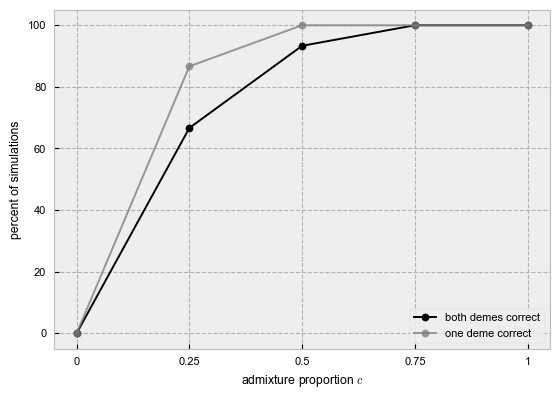

In [401]:
## include a counter for when both nodes are correctly identified and for when one node is correctly identified
# np.savetxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc1edge8x10.txt",llinc)
# llinc0 = np.loadtxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc0edge8x10.txt",skiprows=3)
# topedge.insert(0,'0',[(23,43)]*15)
# sns.swarmplot(data=pd.DataFrame(np.vstack((np.hstack((np.random.choice(llinc0,15).reshape(-1,1),llinc)).flatten(),[0,0.25,0.5,0.75]*15,np.ravel(topedge.apply(lambda x: x==(23,56))))).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8,s=6); plt.legend(title='true edge?'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid(); plt.axhline(15,color='grey',ls='--'); 
# sns.swarmplot(data=pd.DataFrame(np.vstack((lrnidx.flatten()+1,[0.125,0.25,0.375]*15)).T,columns=['lrnidx','c',]),x='c',y='lrnidx',alpha=0.8,s=5,color='k'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('index of true edge'); plt.title('no threshsolding'); plt.grid(); plt.semilogy()
# plt.plot(lrnidx_boot.flatten()+1,lrnidx.flatten()+1,'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()
# get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj)
# plt.plot([0,0.125,0.25,0.375,0.5],np.array([0,2/15,11/15,12/15,13/15])*100,'-o',color='grey',label='both demes correct'); plt.plot([0,0.125,0.25,0.375,0.5],np.array([0,5/15,12/15,15/15,15/15])*100,'-o',color='k',alpha=0.8,label='one deme correct'); plt.ylabel('percent of simulations'); plt.xlabel(r'admixture proportion $c$'); plt.legend()
plt.style.use('seaborn-paper')
plt.plot([0,0.25,0.5,0.75,1],np.array([0,10/15,14/15,15/15,15/15])*100,'-o',color='k',label='both demes correct'); plt.plot([0,0.25,0.5,0.75,1],np.array([0,13/15,15/15,15/15,15/15])*100,'-o',color='grey',alpha=0.8,label='one deme correct'); plt.ylabel('percent of simulations'); plt.xlabel(r'admixture proportion $c$'); plt.legend(loc='lower right'); plt.xticks([0,0.25,0.5,0.75,1],['0','0.25','0.5','0.75','1'])

In [ ]:
# topedge.sum(axis=0)
# edges_lr = deepcopy(edge)
# edges_lr = edges_lr.tolist()
# edges_lr.append([24,57]); edges_lr.append([1,57]); edges_lr.append([73,78])
# sp_Graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(23,56),(0,56),(72,77)])
# sp_Graph_lr.fit(lamb=3.,optimize_q='n-dim')
# [lle[:,ix].max()-lle[x,ix] for ix, x in enumerate(lle[:,:].T.argsort()[:,-2])]
# lle[:,:].T.argsort()[:,-1]
# (lle-np.max(lle,axis=0).T).argsort(axis=0)[-2,:]
# [sorted(i)[-2] for i in zip(*lle)] 
# np.max(lle,axis=0) - np.sort(lle, axis=0)[-2,:] 
# [te.iloc[np.argmax(lle[:,i]),i]==(23,56) for i in range(3)]
# sns.stripplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[1,2,3]*10,topedge)).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8); plt.legend(title='true edge?'); plt.xlabel('# of edges'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid();
# plt.bar(range(4),[5,2,3,0],color='grey',alpha=0.8); plt.xticks(range(4),labels=['0/3','1/3','2/3','3/3']); plt.xlabel('# of edges b/w small demes (in each sim)'); plt.ylabel('total number (across sims)')
# np.random.choice(range(80),8,replace=False)
## just count the number of possible edges bruh...
# s2stot = 0; s2ltot = 0; l2ltot = 0
# for ii in range(80):
#     for jj in range(ii+1,80):
#         if jj in list(sp_Graph.neighbors(ii)):
#             # if neighboring nodes, do not count as potential long range edges
#             continue
#         if ((ii in smallnodes) & (jj in smallnodes)):
#             s2stot += 1
#         elif (((ii in smallnodes) & (jj not in smallnodes)) | ((ii not in smallnodes) & (jj in smallnodes))):
#             s2ltot += 1
#         else:
#             l2ltot += 1

# s2stot, s2ltot, l2ltot, len(sp_Graph.edges)
## binomial proportion test 
# ZZ = (10/25-s2ltot/2955)/np.sqrt((10/25*15/25)/25 + (s2ltot/2955*(2955-s2ltot)/2955)/2955)

### Including unobserved demes in the calculation of the likelihood 

Currently, I assume that all nodes in my grid are observed demes. But this is obviously not the case in real data. So I include a minimal working example with unobserved demes to ensure correct bookkeeping in my code. 

**NEW**: We want to be able to include unsampled demes as a potential source. 

In [398]:
# list(nx.get_node_attributes(graph, "sample_size").values())
sp_graph.q

(76,)

In [396]:
# n_rows, n_cols = 8, 10
# smallnodes = [12, 37, 45, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_cols, corridor_w=1.0, barrier_w=.5, barrier_prob=.3, corridor_left_prob=.8, corridor_right_prob=.6, barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[0 if i in smallnodes else 20 for i in range(80)]) 

# gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, mu=1, long_range_nodes=[(23,56)], admixture_props=[0.5], time_of_adm=[0.000001])

# sp_graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
sp_graph.fit(lamb=3., optimize_q='n-dim')
sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[(23,56)]); sp_graph.c
# get_best_lre(sp_graph,k=2)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='default'); sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc')
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# print(sp_graph.lre,sp_graph.c, obj.neg_log_lik())
# sp_graph.q
# obj.Linv[:sp_graph.n_observednodes,:sp_graph.n_observed_nodes].shape

constant-w/variance fit, converged in 128 iterations, train_loss=22946.383
lambda=3.000, alpha=0.7867, converged in 8 iterations, train_loss=20638.548
lambda=2.000, alpha=0.7895, converged in 2 iterations, train_loss=20638.548


array([0.005])

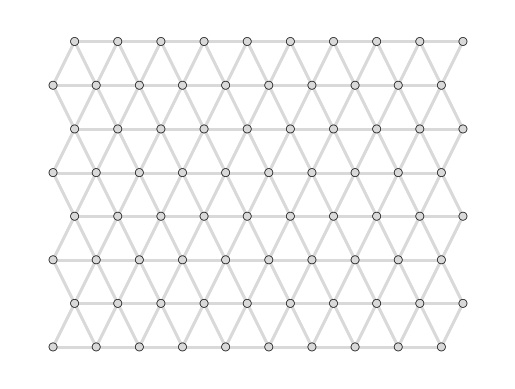

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Tracking lineages that admixed $\tau$ generations ago using the migration matrix 

Here, we want to model the probability of seeing a lineage in deme $d$ in the present day, given that it was actually from from source $s$ but was the result of admixtre $\tau$ generations ago. We can use the migration matrix to evolve these rates forward in time (need to exponentiate?)

From Al-Asadi et al 2019, 
$f_{T_{i,j}}(t) \approx \Big(e^{-Mt} Q e^{-Mt} \Big)$

What if we have different node sizes / diversities? Include a $q$ vector in the calculation of probabilities

In [3400]:
## assuming a 2d grid of 80 demes with an admixture from 12 to 66 2 generations ago (constant migration rate)...
# migmat = deepcopy(sp_graph.W.todense()); #migmat[sp_graph.W.todense()>0] = 1
migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())
np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
# plt.plot(sp_graph.W.todense()[:,66]/sp_graph.W.todense()[:,66].sum()); plt.xlabel('deme ID'); plt.axvline(66,color='grey',linestyle='--'); plt.axvline(12,color='grey',linestyle='--'); plt.title(r'$\tau=0$');
# plt.plot(migmat[:,12]/migmat[:,12].sum()); plt.xlabel('deme ID'); plt.title(r'$\tau=0$'); plt.axvline(66,color='grey',linestyle='--'); plt.axvline(12,color='grey',linestyle='--');
# onehot = np.zeros(80); onehot[45] = 1

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_4061/2573592831.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))


Text(0.5, 1.0, '$\\tau=1$')

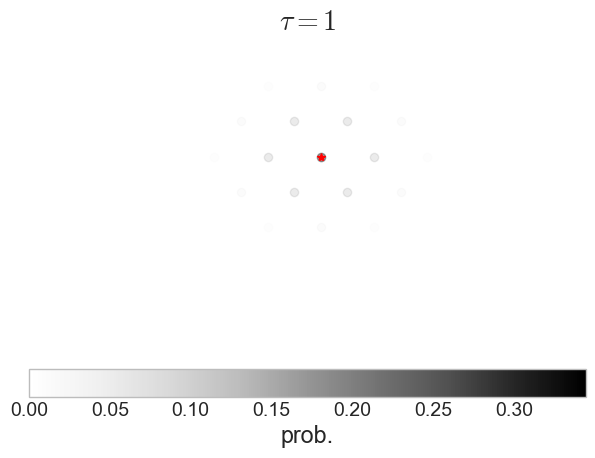

In [3401]:
# ## plotting the grid and seeing where lineages end up
tau = 1
probmat = sp.linalg.expm(migmat*tau)
prod = np.ravel(onehot @ probmat)
for i in range(80):
    plt.plot(grid[i,0],grid[i,1],'o',color='k',alpha=prod[i]); 
plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid(); plt.plot(grid[45,0],grid[45,1],'r*')
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))

### Checking for variability in different FEEMS fits

Run over a baseline 8x10 grid with no admixture edges & grid with one admixture edge ($c=0.5$).  
Measure edge weights, long range edge detection, log-lik, genetic vs fitted distance, with & without penalty (?).  

1. vanilla FEEMS (constant variance)   
    - nll = -46884 with $\lambda_{CV} = 36$
    - nll = -47455 with $\lambda=3$ (log-lik increases with decreasing $\lambda$, but penalty decreases with increasing $\lambda$)
    - $\mu_w$ = 1.7, $\sigma_w$ = 0.14 & $\mu_w$ = 1.73, $\sigma_w$ = 0.37 (respectively)
    - $q$ = 11.2 (stays the same with different $\lambda$)
2. joint FEEMS (None)
    - same behavior as vanilla FEEMS (similar estimates for similar parameters)
3. joint FEEMS ('1-dim')
    - small difference b/w None and '1-dim': weights stay the same, slight change in q & log-lik
4. joint FEEMS ('n-dim')  
    a. setting $\lambda_q$ & $\alpha_q$  
    b. searching over $\lambda_q$ & $\alpha_q$ 

In [ ]:
n_rows, n_columns = 6, 6
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
# gen_test_80 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)

# tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)

# sp_graph = SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=.3); obj = Objective(sp_graph); obj.inv(); 
# np.mean(sp_graph.w), np.std(sp_graph.w)
# fit_cov, _, emp_cov = comp_mats(obj); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2)
# sp_graph.q
## lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv_err = run_cv(sp_graph_jt, lamb_grid, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# print(float(lamb_grid[np.argmin(mean_cv_err)]))

# sp_graph_jt = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph_jt.fit(lamb=3., optimize_q=None); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

# sp_graph_jt.fit(lamb=3., optimize_q='1-dim', lamb_q=0., alpha_q=0.); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

## try it for with both LRE & base graph
# regpath = pd.DataFrame({'lambq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,0], 'alphq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,1],'loglik':np.zeros(36),'loss':np.zeros(36),'muw':np.zeros(36),'sigw':np.zeros(36),'R2':np.zeros(36),'muq':np.zeros(36),'sigq':np.zeros(36)})
# for i in range(regpath.shape[0]):    
#     sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=regpath['lambq'].iloc[i], alpha_q=regpath['alphq'].iloc[i]); 
#     obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
#     fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
#     regpath['loglik'].iloc[i] = -obj_jt.neg_log_lik(); regpath['muw'].iloc[i] = np.mean(sp_graph_jt.w); regpath['sigw'].iloc[i] = np.std(sp_graph_jt.w)
#     regpath['R2'].iloc[i] = sp.stats.linregress(fit_dist, emp_dist)[2]**2; regpath['muq'].iloc[i] = np.mean(sp_graph_jt.q); regpath['sigq'].iloc[i] = np.std(sp_graph_jt.q)
#     print('{}...'.format(i))

# cvq_err = run_cvq(sp_graph_jt, lamb_cv=10., lamb_q_grid=lamb_grid, alpha_q_grid=lamb_grid, factr=1e6)
# lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))]

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1.)
# v = Viz(ax, sp_graph_jt, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)
# v.draw_edge_colorbar()

In [ ]:
# np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2).shape
# regpath.iloc[0,2:8]
# plt.plot(regpath['R2'],'k-o'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel('log-lik'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muw'],'ko'); plt.errorbar(range(36),regpath['muw'],regpath['sigw'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat w$'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muq'],'ko'); plt.errorbar(range(36),regpath['muq'],regpath['sigq'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat q$'); plt.xlabel(r'$\lambda_q, \alpha_q$')

## From msprime documentation: 

Simulating many replicates to get an expectation on the pairwise deme coalescent rates in the presence of an admixture event $\tau$ generatiosn ago with $c$ strength to test the formulae we've calculated

As described in the Definitions section, continuous migration between populations is modelled by a matrix of rates, so that $M[j, k]$ is the rate at which lineages move from population $j$ to population $k$ in the coalescent process, that is, backwards in time (see the Direction of time section for more details). Lineages that move from population $j$ to $k$ backwards in time actually correspond to individuals migrating from population $k$ to $j$ forwards in time.

In [3365]:
n_rows, n_columns = 8, 10
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.2, barrier_w=.2, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=7, n_samples_per_node=20)

# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/")
# for r in range(16):
#     gen_test_1e = simulate_genotypes_w_admixture(graph_def, target_n_snps=500, n_print=400, mu=1, long_range_nodes=[(23,56)], admixture_props=[0.5], time_of_adm=[1], replic=r)
sp_graph = Joint_SpatialGraph(gen_test_1e,coord_def,grid_def,edge_def)
sp_graph.fit(lamb=3., optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# obj.Linv

constant-w/variance fit, converged in 145 iterations, train_loss=28124.924
lambda=3.000, alpha=1.7069, converged in 13 iterations, train_loss=26731.291


In [ ]:
def comp_fst_mat(genotypes, n_inds, n_demes):
    """Computes an Fst distance matrix from a sample
    genotype matrix and set of sub-population ids
    """
    n_snps = genotypes.shape[1]
    acs = np.empty((n_demes, n_snps, 2))
    
    # compute allele counts
    for i in range(n_demes):
        Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
        acs[i, :, 0] = np.sum(Gi, axis=0)
        acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
    # compute Fst matrix
    Fst = np.empty((n_demes, n_demes))
    for i in range(n_demes):
        for j in range(n_demes):
            Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

    for i in range(n_demes):
        Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
    return(Fst)

# Fst = comp_fst_mat(gen_test1,20,12)
# plt.imshow(sp_Graph_asym.S,cmap='RdBu_r'); plt.colorbar()

In [ ]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

In [3323]:
mytree = []
for j in np.arange(500):
    mytree.append(tskit.load(f"feemsResults/trees/mytreewadms{j}_rep0_tau1_c0.5.tree"))

In [3378]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
# origtree = []
# for t in origts.trees():
#     origtree.append(t)

# ndemes = 80; ninds = 2*20; nsnps = 500
# coaltimemat = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for i in range(ninds*ndemes):
#         for j in range(i+1,ninds*ndemes):
#             coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

# coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
# coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

# coaltimemat = coaltimemat + coaltimemat.T
# coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
# coaltimemat /= nsnps

# for rep in range(3,16):
#     mytree = []
#     for j in np.arange(500):
#         mytree.append(tskit.load(f"feemsResults/trees/mytreewadms{j}_rep{rep}_tau1_c0.5.tree"))

#     print(f"Working on rep {rep}...")
#     coaltimemat = np.zeros((ndemes,ndemes))
#     for snp in range(nsnps):
#         tt = mytree[snp].first()
#         for i in range(ninds*ndemes):
#             for j in range(i+1,ninds*ndemes):
#                 coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)
    
#     coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
#     coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds
#     coaltimemat = coaltimemat + coaltimemat.T
#     coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
#     coaltimemat /= nsnps
#     np.savetxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt",coaltimemat)

coaltimemattot = np.zeros((16,80,80))
for rep in range(16):
    coaltimemattot[rep,:,:] = np.loadtxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt")
coaltimemat = np.mean(coaltimemattot,axis=0)
# coaltimemat = np.loadtxt(f"/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat1t1c0.5.txt")

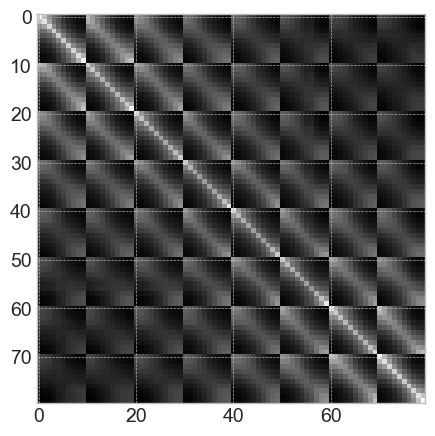

In [3379]:
plt.imshow(coaltimemat)

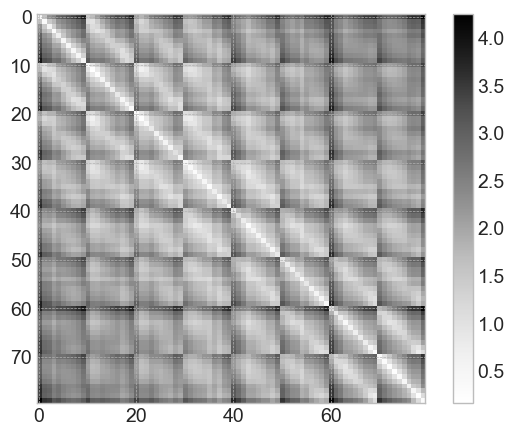

In [3443]:
## writing down the formulae for each pair of demes expected coalescence time
# migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())
migmat = deepcopy(sp_graph.W.todense())
np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
probmat = sp.linalg.expm(migmat*1)

# s, d, c, tau = 23, 56, 0.5, 1
# onehotS = np.zeros(80); onehotD = np.zeros(80); onehotS[s] = 1; onehotD[d] = 1 
probS = np.ravel(onehotS @ probmat); probD = np.ravel(onehotD @ probmat)
nbs = np.where(probS > 0.0)[0]; nbd = np.where(probD > 0.0)[0]
expcoaltime = np.zeros_like(feemscoaltime)
probc = []
for i in range(80):
    for j in range(i,80):
        pis = probS[i]; pjd = probD[j]

        if ((i in nbs) and (j in nbd)):
            prob = pis * pjd * c
            probc.append(prob)
            expcoaltime[i,j] = prob * (2*tau + feemscoaltime[s,s]) + (1-prob) * feemscoaltime[i,j]
        elif ((j in nbs) and (i in nbd)):
            prob = probS[j] * probD[i] * c
            probc.append(prob)
            expcoaltime[i,j] = prob * (2*tau + feemscoaltime[s,s]) + (1-prob) * feemscoaltime[i,j]
        elif (i in nbd) and (j in nbd):
            prob = probS[d] * pjd 
            probc.append(prob)
            expcoaltime[i,j] = prob * (c**2 * (2*tau + feemscoaltime[s,s]) + 2*c*(1-c) * (2*tau + feemscoaltime[s,d]) + (1-c)**2 * (2*tau + feemscoaltime[d,d])) + (1-prob) * feemscoaltime[i,j]
        else:
            expcoaltime[i,j] = feemscoaltime[i,j]

expcoaltime = expcoaltime + expcoaltime.T; np.fill_diagonal(expcoaltime,0.5*np.diag(expcoaltime))
plt.imshow(expcoaltime); plt.colorbar()

In [1]:
# plt.imshow(feemscoaltime-expcoaltime); plt.colorbar()
# sp_graph = Joint_SpatialGraph(gen_test_1e,coord_def,grid_def,edge_def, long_range_edges=[(23,56)])
# sp_graph.fit(lamb=3., optimize_q='n-dim'); sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc'); 
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# print(obj.neg_log_lik())
# plt.hist(np.log10(probc))

NameError: name 'warblr_graph' is not defined

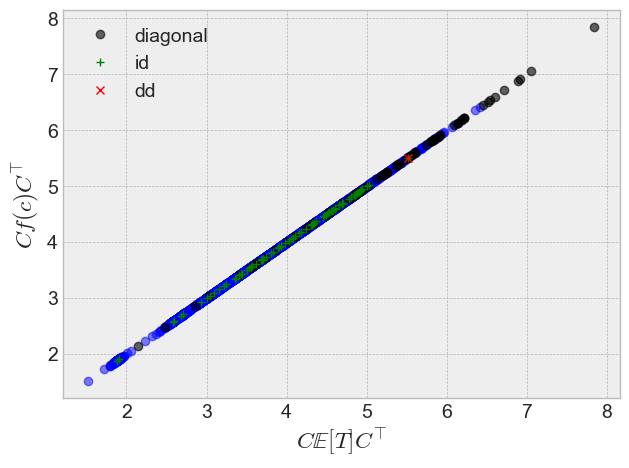

In [3445]:
# plt.imshow(coaltimemat); plt.colorbar()
# plt.plot(np.ravel(-2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1)) + (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))),np.ravel(expcoaltime),'ko')
# feemscoaltime = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1)) + (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
# plt.imshow(C@obscoaltime@C.T); plt.colorbar(); plt.show()
# plt.imshow(C@coaltimemat@C.T); plt.colorbar()
# plt.plot(np.ravel(coaltimemat[np.tril_indices(sp_graph.n_observed_nodes,-1)]),np.ravel(feemscoaltime[np.tril_indices(sp_graph.n_observed_nodes,-1)])*500/4,'ko',alpha=0.5); plt.axline((200,200),slope=1,color='grey')
# plt.plot(-np.ravel((C@coaltimemat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),-np.ravel((C@feemscoaltime@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),'bo',alpha=0.5); plt.plot(-np.diag(C@coaltimemat@C.T),-np.diag(C@feemscoaltime@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(-(C@coaltimemat@C.T)[:,lrn[0][1]-1],-(C@feemscoaltime@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot(-(C@coaltimemat@C.T)[lrn[0][1]-1,lrn[0][1]-1],-(C@feemscoaltime@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend(); plt.ylabel(r'$C(R+q)C^\top$'); plt.xlabel(r'$C\mathbb{E}[T]C^\top$'); 

# plt.plot(-np.ravel((C@coaltimemat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),-np.ravel((C@expcoaltime@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),'bo',alpha=0.5); plt.plot(-np.diag(C@coaltimemat@C.T),-np.diag(C@expcoaltime@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(-(C@coaltimemat@C.T)[:,lrn[0][1]-1],-(C@expcoaltime@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot(-(C@coaltimemat@C.T)[lrn[0][1]-1,lrn[0][1]-1],-(C@expcoaltime@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend(); plt.ylabel(r'$Cf(c)C^\top$'); plt.xlabel(r'$C\mathbb{E}[T]C^\top$'); 

plt.plot(-np.ravel((C@feemscoaltime@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),-np.ravel((C@expcoaltime@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)]),'bo',alpha=0.5); plt.plot(-np.diag(C@feemscoaltime@C.T),-np.diag(C@expcoaltime@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(-(C@feemscoaltime@C.T)[:,lrn[0][1]-1],-(C@expcoaltime@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot(-(C@feemscoaltime@C.T)[lrn[0][1]-1,lrn[0][1]-1],-(C@expcoaltime@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend(); plt.ylabel(r'$Cf(c)C^\top$'); plt.xlabel(r'$C\mathbb{E}[T]C^\top$'); 

# plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-0.5*C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.xlabel(r'$pC\hat \Sigma C^\top$'); plt.ylabel(r'$-\frac{1}{2}C\Delta C^\top$'); plt.plot(np.diag(sp_graph.n_snps*C@sp_graph.S@C.T),np.diag(-0.5*C@resmat@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],(-0.5*C@resmat@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-0.5*C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend();